# 📌[2주차/기본] 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

이번 과제에서는 Transformer를 last word prediction이라는 task에 적용합니다.
Last word prediction은 Token list가 주어졌을 때, 다음으로 오는 token을 예측하는 task로, 추후 등장할 LLM의 핵심입니다.

In [1]:
!pip install datasets sacremoses


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

### 📄 데이터 로딩

IMDb (Internet Movie database)

train 25000개 와 test 25000개로 이루어져 있다.

#### 🔍 라벨
0 : 부정적인 리뷰
1 : 긍정적인 리뷰

#### 📦 샘플
```python
{
  'text': "I watched this movie with my family and we all hated it. The story was weak...",
  'label': 0
}
```

In [3]:
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

🔤 tokenizer 설정

huggingface에서 bert-base-uncased 모델을 불러와서 설정을 한다.

* 토큰화 방식
 * BERT : 단어를 서브워드 단위로 분해
 * BPE : 자주 등장하는 문자쌍을 병합
 * SentencePiece : 공백까지 포함해서 분해

* 대소문자 처리
 * uncased : 모두 소문자로 치환
 * cased : 대소문자 유지



In [4]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

Using cache found in /home/jovyan/.cache/torch/hub/huggingface_pytorch-transformers_main


📦 collate_fn

text 데이터는 샘플마다 문장 길이가 다르기 때문에 padding이 필요하다
* tokenizer
 * padding=True : 짧은 문장도 padding을 사용해서 일정한 길이로 맞춰준다..
 * truncation : 너무 긴 문장은 max_len 기준으로 자름

🌟 기존 감정 분류와 달라진 점

기본 과제에선 label에 input_ids[-2] 를 넣어주고 있는데, 이는 마지막 단어 예측이 우리 모델의 목표이기 때문이다.


In [5]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-3])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

## ✏️ Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.

여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.

* forward에서 필요한 입력
 * x : 입력 시퀀스
 * mask : 패딩 토큰 무시하거나 casual attention 하는 경우 필요


In [6]:
from torch import nn
from math import sqrt

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model) #in : (B,S,D) output: (B,S,d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)

        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q = self.wq(x) #(B,S,d_model)
        k = self.wk(x)
        v = self.wv(x)

        score= torch.matmul(q, k.transpose(-1,-2)) # 뒤에서 첫번째 두번째를 바꿔준다 k.transpose = (B,d_model,S) score = (B,S,S)
        score = score / sqrt(self.d_model)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        result = torch.matmul(score, v)
        result = self.dense(result)

        return result

대부분 transformer 구조에 대해 그냥 구현한 것에 불과하지만 mask는 새로운 개념

단어와 단어 사이의 관계도를 보는 Attention score에서 실제 단어와 패딩 단어 사이의 관계도를 고려할 필요가 전혀 없기 때문에 -1e-9를 더하여, 소프트맥스에서 확률 0이 출력되도록 만든 것입니다

---
### 🧱 TransformerLayer

* Self-Attention : 이미 구현해둔 class 사용
* Feed-Forward Network (FFN) : MLP 구조 (Linear > ReLU > Linear)
  * 각 토큰 하나하나에 대해 독립적으로 처리하는 fully connected network


🧠 요약

Attention : token간 관계 표현 개선

FFN : 각 토큰 자체의 표현 개선


In [8]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

## 🧮 Positional encoding

* 순서 정보를 인코딩해서 모델에 넣어주는 기술
* 각 위치마다 고유한 벡터를 만들어서 입력 임베딩에 더해주는 방식
* Transformer는 Attention 구조라서 문장을 볼때 병렬로 처리하기 때문에 RNN 처럼 순차적 처리가 되지 않음. 따라서 명시적으로 알려줘야 한다.

```python
x = token_embedding + positional_encoding
```

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

In [9]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


---
## 🔧 LastWordPredictor (basic 과제)

#### ⁉️ 변경 사항
1. 단어 예측 task인 만큼 tokenizer의 vocab_size로 최종 출력 차원을 조정해준다.
2. 문장의 첫번째 토큰 벡터를 뽑는 코드를 삭제하고 마지막 토큰을 뽑도록 한다

#### ⁉️ sqrt(d_model) 하는 이유
embedding된 벡터는 작은 값인데, positional encoding은 값이 커서 positional encoding의 영향이 너무 큼 > scale up


In [10]:
class LastWordPredictor(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model) # d_model의 차원의 벡터로 embedding
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)]) # n_layer만큼 transformerLayer를 쌓음
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    #패딩 토큰을 찾아서 mask 생성
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :] # (B,1,S)

    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]
    x = self.classification(x)

    return x


## 학습

#### 🔧 변경사항
* loss_fn 이 BCEWithLigitsLoss 는 이진 분류를 위한 것 이므로 변경
* preds 구하는 법과 label을 정수형으로 변경

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [12]:
def model_train(model, n_epochs):
    train_acc_list = []
    test_acc_list = []
    train_losses = []

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss)
        print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
    return train_losses, train_acc_list, test_acc_list

In [13]:
from torch.optim import Adam
##hyperparam
n_epochs = 10
lr = 0.001


model = LastWordPredictor(len(tokenizer), 32, 2, 64)
model = model.to('cuda')

loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

train_losses, train_acc_list, test_acc_list = model_train(model, n_epochs)

Epoch   0 | Train Loss: 205.60979747772217
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   1 | Train Loss: 178.1094732284546
=========> Train acc: 0.038 | Test acc: 0.027
Epoch   2 | Train Loss: 138.7589783668518
=========> Train acc: 0.034 | Test acc: 0.034
Epoch   3 | Train Loss: 125.07829093933105
=========> Train acc: 0.041 | Test acc: 0.023
Epoch   4 | Train Loss: 120.8176679611206
=========> Train acc: 0.042 | Test acc: 0.026
Epoch   5 | Train Loss: 118.85170078277588
=========> Train acc: 0.042 | Test acc: 0.024
Epoch   6 | Train Loss: 117.80805397033691
=========> Train acc: 0.040 | Test acc: 0.022
Epoch   7 | Train Loss: 117.15645503997803
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   8 | Train Loss: 117.00370216369629
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   9 | Train Loss: 116.3481764793396
=========> Train acc: 0.042 | Test acc: 0.023


In [16]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(epochs, train_losses, marker='o', linestyle='-', color='blue')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_accs, marker='o', linestyle='-', label='Train Accuracy', color='green')
    ax2.plot(epochs, test_accs, marker='x', linestyle='--', label='Test Accuracy', color='red')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


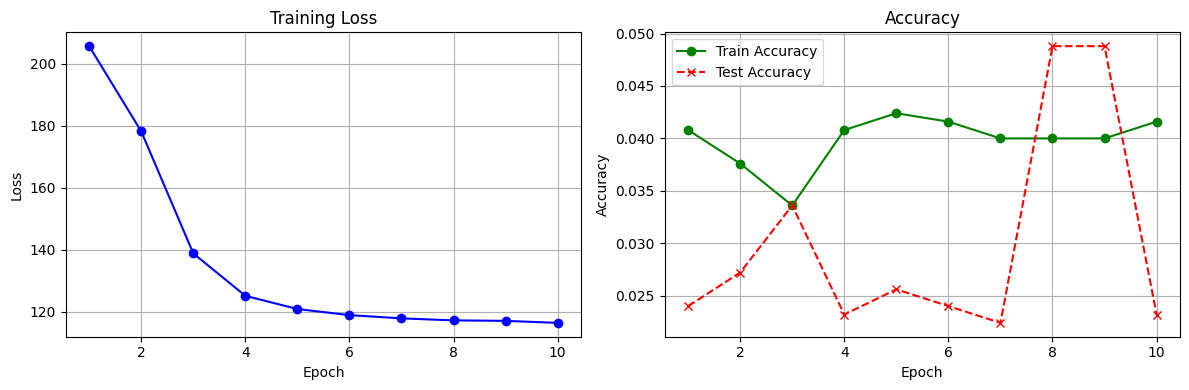

In [17]:
plot_metrics(train_losses, train_acc_list, test_acc_list)

### 💭 결과
* loss 는 잘 줄어들고 있음
* train test accuracy는 크게 개선되지 않음
* 기존 -2 일때는 . 으로 predict 하면 60% 정도는 맞았던거 같은데 오히려 -3 을 하고 나서 정확도가 나오지 않음 (당연한 것 같기도 함)

### 🚩 의심가는 점
* 학습 데이터 늘려서 해볼 수 있는지
* 아니면 fail나는거 한번 까보기

---


In [18]:
import pandas as pd

def save_predictions_to_excel(model, dataloader, tokenizer, filename="predictions.csv"):
    model.eval()
    results = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            for i in range(inputs.size(0)):
                input_ids = inputs[i].tolist()
                input_tokens = tokenizer.convert_ids_to_tokens(input_ids)
                input_text = tokenizer.convert_tokens_to_string(input_tokens)

                pred_id = preds[i].item()
                label_id = labels[i].item()

                pred_token = tokenizer.convert_ids_to_tokens([pred_id])[0]
                label_token = tokenizer.convert_ids_to_tokens([label_id])[0]
                correct = pred_id == label_id

                results.append({
                    "Input Text": input_text,
                    "Target Token": label_token,
                    "Predicted Token": pred_token,
                    "Correct": correct
                })

    df = pd.DataFrame(results)
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Saved {len(results)} predictions to {filename}")

    return df

df = save_predictions_to_excel(model, test_loader, tokenizer)

Saved 1250 predictions to predictions.csv


|input|label|pred|
|--|--|--|
|[CLS] i was pulled into this movie early on, much to my surprise, because i hadn ' t intended to watch it at all. now i wish i hadn ' t. the suspense starts out well, with the hit - and - run resulting in death and the question of whether the guilty character will confess, or be found out, or ( doable now, though a no - no in the old days of movie - making ) get away with it. the plot ' s been done before - - what plot hasn ' t - - but the tensions inherent in it, with the additional complications and motivations arising out of the illicit love affair, make for an absorbing first half. then the film abandons the hit - and - run to embark upon a misty exposition of two unrequited, all - suffering loves. the two tracks of plot - - hit - and - run and unreasoning love - - just don ' t have enough to do with each other, and that they involve the same characters doesn ' t bind them enough to justify the departure from the original story line. the screenwriter should have chosen one plot or the other. at the end of the film, in the midst of the movie ' s second funeral, i found myself thinking, " now, what does any of this have to do with that hit - and - run? " the filmmakers may think the answer obvious, but i think the movie was plotted and executed flabbil [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]	|##y	|/|
|[CLS] i ' m a huge fan of both emily watson ( breaking the waves ) and tom wilkinson ( normal ) and was amused to see them upstaged by rupert everett ( dellamorte dellamore ) in this shockingly rather minor movie that had all the ingredients to be so much more. the too brief scenes in which he portrays a languid, infinitely entitled, worthless son of a rich lord are spot - on and entertaining. but for a love triangle there was remarkably little chemistry to speak of between anyone. the music was annoyingly movie - of - the - week quality, and the voice - over jarring and totally unnecessary. clearly the work of a first - time director with a small budget who either lacked or didn ' t sufficiently heed good advice. too bad. < br / > < br / > i can appreciate how the people you kind of hate at the beginning are the ones you kind of like at the end, and vice - versa, so there is some sort of character arc, at least in terms of perception. for example, watson ' s character, while refreshingly honest to her husband about her feelings for another man, began to grate on me near the end, particularly when she announced to her husband that she simply had absolutely no control over her actions, and later when she simply declared that she would be moving back into their marital flat, with no asking of permission, no apologies offered. and i went from disliking wilkinson ' s control freak / moral relativist character to sort of understanding him and not really wanting him to change ( unlike his wife ). < br / > < br / > this movie awkwardly morphed from a whodunit to a " love story " or " steel magnolias " illness drama without sufficiently informing me of the fact, so i was left distractedly guessing what the next plot twist might be long after they had all been revealed ( was it the lord driving the car? the lord	|'|.|


In [19]:
list(set(df['Predicted Token'].tolist()))

['.', '/']

학습 결과를 보면 .과 / 으로만 내뱉고 있는 걸 알 수 있다.
그래서 그냥 저 두개 중에 찍어서 맞으면 정답이라고 하는 정도인 것 같음

* 여러번 학습 해봤는데 특수문자만 나오는건 아니고 her .. 등등이 타겟이 될 때도 있음 (데이터 따라)

In [21]:
from collections import Counter

label_counter = Counter()

for batch in train_loader:
    _, labels = batch
    label_tokens = tokenizer.convert_ids_to_tokens(labels.view(-1).tolist())
    label_counter.update(label_tokens)

print(label_counter)

Counter({'/': 51, '.': 50, 'it': 42, 'film': 26, '!': 25, 'one': 25, 'movie': 20, '*': 20, 'the': 17, '"': 15, 'of': 15, '10': 14, 'this': 11, 'bad': 10, ')': 10, 'all': 10, 'time': 9, '##s': 9, ',': 9, '-': 8, 'you': 8, 'me': 7, 'to': 7, 'a': 7, 'that': 7, 's': 6, ':': 6, "'": 6, 'do': 5, 'did': 5, 'not': 5, 'funny': 5, '2': 5, '<': 5, 'off': 5, 'again': 5, 'well': 5, 'ever': 5, '>': 5, 'disappointing': 5, 'i': 5, '?': 5, 'long': 4, 'and': 4, 'warned': 4, 'more': 4, 'else': 4, 'life': 4, 'trash': 4, 'here': 4, 'good': 4, 'avoid': 4, 'seen': 4, 'show': 3, 'hours': 3, 'yourself': 3, '##er': 3, 'instead': 3, 'plot': 3, 'cinema': 3, '##d': 3, 'costs': 3, 'her': 3, 'down': 3, 'made': 3, 'sorry': 3, 'movies': 3, 'for': 3, '##ity': 3, 'in': 3, 'rubbish': 3, 'story': 3, 'is': 3, 'only': 3, 'thing': 3, 'kids': 3, 'at': 3, 'cast': 3, 'back': 3, 'money': 3, 'entertaining': 3, 'work': 2, 'way': 2, 'four': 2, 'sucked': 2, 'happened': 2, 'easy': 2, 'scripts': 2, 'first': 2, 'looking': 2, 'fans': 2,

역시 . / 가 데이터 중 label 에 제일 많은 걸 알 수 있다.

---

### model 2

1. 더 많은 데이터 사용 : 5%가 아니라 10% 데이터 사용
2. 데이터 전처리 : 특수문자 제거
3. 

In [32]:
train_ds_2 = load_dataset("stanfordnlp/imdb", split="train[:10%]")
test_ds_2 = load_dataset("stanfordnlp/imdb", split="test[:10%]")

print(len(test_ds_2))

2500


In [33]:
train_ds_2[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

#### 데이터 전처리
clean_text 함수를 통해 아래와 같은 전처리를 진행해본다.
* 소문자 변환
* <\br> 태그 제거
* 알파벳 공백 제외 제거
* 중복 공백 제거

In [57]:
import re

def clean_text(example):
    example['text'] = example['text'].lower()
    example['text'] = re.sub(r"<br\s*/?>", " ", example["text"])
    example['text'] = re.sub(r"[^a-z\s]", " ", example["text"])
    example['text'] = re.sub(r"\s+", " ", example["text"]).strip()
    return example

train_ds_2 = train_ds_2.map(clean_text)
test_ds_2 = test_ds_2.map(clean_text)


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [58]:
train_ds_2[0]

{'text': 'i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in i also heard that at first it was seized by u s customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myself the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married men what kills me about i am curious yellow is that years ago this was considered pornographic really the sex and nudity scenes are few and far between even then it s not shot like some cheap

In [59]:
train_loader_2 = DataLoader(
    train_ds_2, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader_2 = DataLoader(
    test_ds_2, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [60]:
class LastWordPredictor2(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model) # d_model의 차원의 벡터로 embedding
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)]) # n_layer만큼 transformerLayer를 쌓음
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    #패딩 토큰을 찾아서 mask 생성
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :] # (B,1,S)

    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]
    x = self.classification(x)

    return x


model2 = LastWordPredictor2(len(tokenizer), 32, 2, 32)

In [61]:
def model_train_2(model, n_epochs):
    train_acc_list = []
    test_acc_list = []
    train_losses = []

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        for data in train_loader_2:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss)
        print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader_2)
            test_acc = accuracy(model, test_loader_2)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
    return train_losses, train_acc_list, test_acc_list

In [62]:
from torch.optim import Adam
##hyperparam
n_epochs = 5
lr = 0.001

model2 = model2.to('cuda')

loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model2.parameters(), lr=lr)

train_losses, train_acc_list, test_acc_list = model_train_2(model2, n_epochs)

Epoch   0 | Train Loss: 388.4913101196289
=========> Train acc: 0.048 | Test acc: 0.040
Epoch   1 | Train Loss: 277.0259585380554
=========> Train acc: 0.049 | Test acc: 0.060
Epoch   2 | Train Loss: 250.96477508544922
=========> Train acc: 0.048 | Test acc: 0.039
Epoch   3 | Train Loss: 244.38047695159912
=========> Train acc: 0.049 | Test acc: 0.060
Epoch   4 | Train Loss: 242.3260154724121
=========> Train acc: 0.048 | Test acc: 0.040


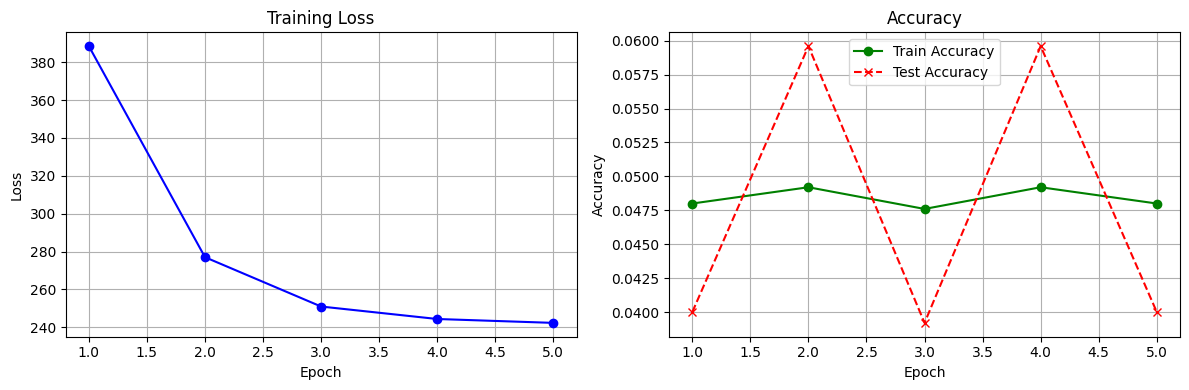

In [63]:
plot_metrics(train_losses, train_acc_list, test_acc_list)

In [64]:
df2 = save_predictions_to_excel(model2, test_loader_2, tokenizer)

Saved 2500 predictions to predictions.csv


In [65]:
df2.head()

,Input Text,Target Token,Predicted Token,Correct
0,[CLS] i love sci fi and am willing to put up w...,over,this,False
1,[CLS] worth the entertainment value of a renta...,pass,this,False
2,[CLS] its a totally average film with a few se...,directed,this,False
3,[CLS] star rating saturday night friday night ...,the,this,False
4,[CLS] first off let me say if you haven t enjo...,fun,this,False


In [66]:
from collections import Counter

label_counter = Counter()

for batch in train_loader_2:
    _, labels = batch
    label_tokens = tokenizer.convert_ids_to_tokens(labels.view(-1).tolist())
    label_counter.update(label_tokens)

print(label_counter)

Counter({'the': 123, 'this': 120, 'of': 88, 'a': 80, 'to': 58, 'it': 45, 'for': 45, 'out': 43, 'and': 34, 'in': 33, 'is': 26, 's': 24, 'that': 22, 'movie': 19, 'all': 19, 'was': 15, 'as': 15, 'be': 14, 'your': 14, 'very': 13, 't': 13, 'more': 13, 'bad': 13, 'good': 13, 'so': 12, 'not': 12, 'at': 12, 'been': 12, 'about': 11, 'see': 11, 'just': 11, 'my': 11, 'too': 11, 'ever': 10, 'you': 9, 'i': 9, 'like': 9, '##s': 9, 'film': 8, 'than': 8, 'watch': 8, 'by': 8, 'horror': 8, 'one': 8, 'me': 8, 'on': 8, 'get': 8, 'other': 8, 'with': 7, 'time': 7, 'even': 7, 'up': 7, 'his': 7, 'never': 7, 'really': 7, 'great': 6, 'were': 6, 'every': 6, 'have': 6, 'any': 6, 'better': 6, 'from': 6, 'an': 6, 'watching': 6, 'can': 6, 'first': 6, 'being': 5, 'would': 5, 'seen': 5, 'worth': 5, 'new': 5, 'no': 5, 'but': 5, '##y': 5, 'much': 5, 'them': 5, 'big': 5, 'own': 5, 'skip': 5, 'its': 5, 'something': 5, 'recommend': 5, 'sell': 4, 'original': 4, 'avoid': 4, 'long': 4, 'family': 4, 'mer': 4, 'anything': 4, 'd

In [67]:
print(df2['Predicted Token'].unique())
print(df2['Target Token'].unique())


['this']
['over' 'pass' 'directed' 'the' 'fun' 'generic' 't' 'this' 'it' 'action'
 'little' 'then' 'to' 'house' 'very' 'lucky' 'british' 'owe' '##ik' 'a'
 'for' 'gee' 'out' 'won' 'want' 'garbage' 'of' 'restaurant' 'film' 'burn'
 'his' 'can' 'producer' 'all' 'set' 'enjoy' 'captain' 'pleasant' 'ending'
 'with' 'and' 'is' 'movie' 'one' 'at' 's' 'get' 'about' '##sel' 'just'
 'than' 'moving' '##iche' 'dark' 'isn' 'my' 'careless' 'parking' 'vane'
 'real' 'any' 'else' 'major' 'your' 'say' 're' '##s' 'inability' 'its'
 '##db' 'wasted' 'their' 'decent' 'has' 'lines' 'grade' '##ly' 'or'
 'others' 'killing' 'tired' 'worth' '##wn' 'through' '##se' 'got' 'no'
 'was' 'into' 'first' '##ze' 'hour' 'me' 'mummy' 'o' 'seen' 'anything'
 'basic' 'wash' 'i' 'as' 'great' 'if' 'mercy' 'video' 'in' 'kid' 'on'
 '##hin' 'suffer' 'book' 'some' 'began' 'quite' '##gra' 'inside' 'called'
 'shame' 'he' 'regret' 'happy' 'so' 'best' 'see' 'better' 'red' 'l' 'use'
 'avant' 'tracking' 'not' 'cinematography' 'explain' 'ev

#### 🚩 model2 결과
데이터를 늘려보고 전처리를 해줬지만 크게 acc가 늘어나는 모습은 보이지 않음. 한계인건지 궁금

🔺 전처리는 생각해보니 오히려 acc가 낮아지는 원인인 것 같다. (특수문자는 대충 때려맞추면 되는데 단어가 더 어려움)
🔺 근데 그것도 아닌 것 같기도.. 그냥 제일 많은 1~2개로 도배하는 것 같다

---

데이터가 부족하면 아래처럼 augmentation 해줄 수 있는데 data의 문제라기 보다는 적합하지 않은 모델인 것 같다.
+ 애매한 데이터와 애매한 task

In [ ]:
def augment_sentence(example, max_len=400):
    text = example['text']
    label = example['label']

    input_ids = tokenizer.encode(text, truncation=True, max_length=max_len)

    samples = []
    for i in range(4, len(input_ids)):
        partial_ids = input_ids[:i+1]
        decoded_text = tokenizer.decode(partial_ids, skip_special_tokens=True)
        samples.append((decoded_text, label))

    return samples

augmented_data = []
for example in tqdm(train_ds, desc="Augmenting"):
    augmented_data.extend(augment_sentence(example))

print("총 샘플 수:", len(augmented_data))

In [53]:
from torch.utils.data import Dataset

class AugmentedIMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, label = self.data[idx]
        return {"text": input_ids, "label": label}

In [54]:
augmented_dataset = AugmentedIMDBDataset(augmented_data)

train_loader_3 = DataLoader(
    augmented_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn_2
)